In [1]:
import requests, sklearn, numpy as np, json, pandas as pd
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

In [2]:
def get_dataset(split):
  """
  split: 'train', 'test', 'validation'
  """
  res = requests.get(f"https://datasets-server.huggingface.co/first-rows?dataset=conll2003&config=conll2003&split={split}")
  data_raw = res.content.decode("utf-8") 
  data = json.loads(data_raw)
  rows = [row['row'] for row in data['rows']]
  df = pd.DataFrame(rows)
  return df

In [3]:
# getting train/test datasets

df_train = get_dataset('train')
df_validation = get_dataset('validation')
df_test = get_dataset('test')

df_train.head(5)

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [4]:
# converting list of sentences into one long sequence of words

def flatten(l):
    return np.asarray([item for sublist in l for item in sublist])

def lowercase(l):
    return np.asarray([word.lower() for word in l])

def make_X_y(df):
  X_sentences = df['tokens'].to_numpy()
  y_sentences = df['ner_tags'].to_numpy()
  
  # X = np.asarray([np.asarray(i) for i in X_sentences])
  X = lowercase(flatten(X_sentences))
  y = flatten(y_sentences)
  y = tf.one_hot(y, 9)

  return X, y

X_train, y_train = make_X_y(df_train)
X_val, y_val = make_X_y(df_validation)
X_test, y_test = make_X_y(df_test)

X_full = np.concatenate([X_train, X_val, X_test])

print(X_train[:5])
print(y_train[:5])

['eu' 'rejects' 'german' 'call' 'to']
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 9), dtype=float32)


In [5]:
# downloading glove

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-15 08:58:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-15 08:58:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-15 08:58:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [6]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip    sample_data
glove.6B.200d.txt  glove.6B.50d.txt   glove.6B.zip.1


In [7]:
# make a dict mapping words (strings) to their NumPy vector representation

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [8]:
vectorizer = TextVectorization(max_tokens=20000)
text_ds = tf.data.Dataset.from_tensor_slices(X_full).batch(128)
vectorizer.adapt(X_full)
print(vectorizer.get_vocabulary()[:5])

['', '[UNK]', 'the', 'to', 'a']


In [9]:
# let's see how the vectorized sentence looks like

for i in range(15):
  output = vectorizer([[X_train[i]]])
  print(X_train[i], y_train[i], output.numpy())

eu tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[129]]
rejects tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[803]]
german tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float32) [[71]]
call tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[527]]
to tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[3]]
boycott tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[1290]]
british tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float32) [[72]]
lamb tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[252]]
. tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) []
peter tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[395]]
blackburn tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32) [[532]]
brussels tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float32) [[1279]]
1996-08-22 tf.Tensor([1. 0. 0. 0.

In [10]:
# making the word index

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [11]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1406 words (111 misses)


In [12]:
from tensorflow.keras.layers import Embedding
import keras

# create the embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [13]:
from tensorflow.keras import layers

# build the model
int_sequences_input = keras.Input(shape=(1,))
embedded_sequences = embedding_layer(int_sequences_input)

# Add 2 bidirectional LSTMs
x = layers.LSTM(64)(embedded_sequences)
# x = layers.LSTM(64)(x)
# Add a classifier
outputs = layers.Dense(9, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 100)            151900    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 194,725
Trainable params: 42,825
Non-trainable params: 151,900
_________________________________________________________________


In [17]:
# convert our word data to NumPy arrays of integer indices

X_train_indices = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val_indices = vectorizer(np.array([[s] for s in X_val])).numpy()
X_test_indices = vectorizer(np.array([[s] for s in X_test])).numpy()

# example of training data
for i in zip(X_train[0:10], X_train_indices[0:10]):
  print(i)

<class 'tensorflow.python.framework.ops.EagerTensor'>
('eu', array([129]))
('rejects', array([803]))
('german', array([71]))
('call', array([527]))
('to', array([3]))
('boycott', array([1290]))
('british', array([72]))
('lamb', array([252]))
('.', array([0]))
('peter', array([395]))


In [15]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train_indices, y_train, epochs=100,
          validation_data=(X_val_indices, y_val))

Epoch 1/100
52/52 [==============================] - 3s 17ms/step - loss: 0.4925 - accuracy: 0.7428 - val_loss: 0.3357 - val_accuracy: 0.7911
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 0.2399 - accuracy: 0.8412 - val_loss: 0.2523 - val_accuracy: 0.7926
Epoch 3/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1905 - accuracy: 0.8430 - val_loss: 0.2279 - val_accuracy: 0.7985
Epoch 4/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1642 - accuracy: 0.8490 - val_loss: 0.2099 - val_accuracy: 0.8037
Epoch 5/100
52/52 [==============================] - 0s 5ms/step - loss: 0.1437 - accuracy: 0.8762 - val_loss: 0.1949 - val_accuracy: 0.8126
Epoch 6/100
52/52 [==============================] - 0s 5ms/step - loss: 0.1269 - accuracy: 0.8943 - val_loss: 0.1810 - val_accuracy: 0.8170
Epoch 7/100
52/52 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.9010 - val_loss: 0.1689 - val_accuracy: 0.8141
Epoch 8/100


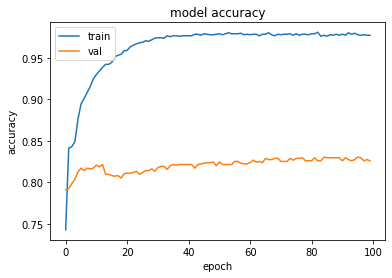

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# accuracy on the test set

metric_accuracy = tf.keras.metrics.Accuracy()
predictions = model.predict(X_test_indices)

metric_accuracy.update_state(tf.argmax(predictions, 1), tf.argmax(y_test,1))
metric_accuracy.result().numpy()


45/45 [==============================] - 0s 2ms/step


0.84388185

# Exercise 6.2

The advantage of using RNN is that they have internal state and can renember previous input. This is useful because named entities often come in specific context, i.e. preceded by 'the': 'the EU'